# Solving the permuted sequential MNIST (psMNIST) task

The psMNIST (Permuted Sequential MNIST) task is a image classification task introduced
in 2015 by Le, Jaitly, and Hinton ([see paper](https://arxiv.org/pdf/1504.00941.pdf)).
It is based on the Sequential MNIST task, which itself is a derivative of the MNIST
task. Like the MNIST task, the goal of the psMNIST task is to have a neural network
process a 28 x 28 pixel image (of a handwritten digit) into one of ten digits (0 to 9).

However, while the MNIST task presents the entire image to the network all at once, the
Sequential MNIST and psMNIST tasks turn the image into a stream of 784 (28x28)
individual pixels, presented to the network one at a time. The goal of the network is
then to classify the pixel sequence as the appropriate digit after the last pixel has
been shown. The psMNIST task adds more complexity to the input by applying a fixed
permutation to all of the pixel sequences. This is done to ensure that the information
contained in the image is distributed evenly throughout the sequence, so that in order
to perform the task successfully, the network needs to process information across the
whole length of the input sequence.

The following notebook uses a single KerasLMU layer inside a simple TensorFlow model to
showcase the accuracy and efficiency of performing the psMNIST task using these novel
memory cells. Using the LMU for this task currently produces state-of-the-art results
this task ([see
paper](https://papers.nips.cc/paper/9689-legendre-memory-units-continuous-time-representation-in-recurrent-neural-networks.pdf)).

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display
import tensorflow as tf

import keras_lmu

## Loading and formatting the dataset

First we set a seed to ensure that the results in this example are reproducible. A
random number generator state (`rng`) is also created, and this will later be used to
generate the fixed permutation to be applied to the image data.

In [2]:
seed = 0
tf.random.set_seed(seed)
np.random.seed(seed)
rng = np.random.RandomState(seed)

We now obtain the standard MNIST dataset of handwritten digits from `tf.keras.datasets`.

In [3]:
(train_images, train_labels), (
    test_images,
    test_labels,
) = tf.keras.datasets.mnist.load_data()

    8192/11490434 [..............................] - ETA: 0s

 4956160/11490434 [===========>..................] - ETA: 0s

 8396800/11490434 [====================>.........] - ETA: 0s

11493376/11490434 [==============================] - 0s 0us/step


Since the pixel values of each image in the dataset have a range of 0 to 255, they are
divided by 255 to change this range to 0 to 1. Let's also display a sample image from
the MNIST dataset to get an idea of the kind of images the network is working with.

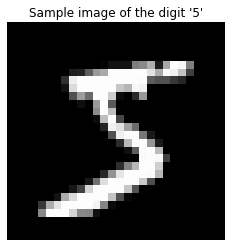

In [4]:
train_images = train_images / 255
test_images = test_images / 255

plt.figure()
plt.imshow(np.reshape(train_images[0], (28, 28)), cmap="gray")
plt.axis("off")
plt.title(f"Sample image of the digit '{train_labels[0]}'")
plt.show()

Next, we have to convert the data from the MNIST format into the sequence of pixels that
is used in the psMNIST task. To do this, we flatten the image by calling the `reshape`
method on the images. The first dimension of the reshaped output size represents the
number of samples our dataset has, which we keep the same. We want to transform each
sample into a column vector, and to do so we make the second and third dimensions -1 and
1, respectively, leveraging a standard NumPy trick specifically used for converting
multi-dimensional data into column vectors.

The image displayed below shows the result of this flattening process, and is an example
of the type of data that is used in the Sequential MNIST task. Note that even though the
image has been reshaped into an 98 x 8 image (so that it can fit on the screen), there
is still a fair amount of structure observable in the image.

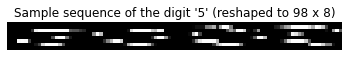

In [5]:
train_images = train_images.reshape((train_images.shape[0], -1, 1))
test_images = test_images.reshape((test_images.shape[0], -1, 1))

# we'll display the sequence in 8 rows just so that it fits better on the screen
plt.figure()
plt.imshow(train_images[0].reshape(8, -1), cmap="gray")
plt.axis("off")
plt.title(f"Sample sequence of the digit '{train_labels[0]}' (reshaped to 98 x 8)")
plt.show()

Finally, we apply a fixed permutation on the images in both the training and testing
datasets. This essentially shuffles the pixels of the image sequences in a consistent
way, allowing for images of the same digit to still be similar, but removing the
convenience of edges and contours that the network can use for easy digit inference.

We can see, from the image below, that the fixed permutation applied to the image
creates an even distribute of pixels across the entire sequence. This makes the task
much more difficult as it makes it necessary for the network to process the entire input
sequence to accurately predict what the digit is. We now have our data for the Permuted
Sequential MNIST (psMNIST) task.

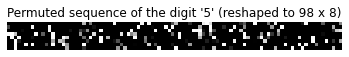

In [6]:
perm = rng.permutation(train_images.shape[1])
train_images = train_images[:, perm]
test_images = test_images[:, perm]

plt.figure()
plt.imshow(train_images[0].reshape(8, -1), cmap="gray")
plt.axis("off")
plt.title(f"Permuted sequence of the digit '{train_labels[0]}' (reshaped to 98 x 8)")
plt.show()

From the images in the training set, we allocate the first 50,000 images for training,
and the remaining 10,000 for validation. We print out the shapes of these datasets to
ensure the slicing has been done correctly.

In [7]:
X_train = train_images[0:50000]
X_valid = train_images[50000:]
X_test = test_images

Y_train = train_labels[0:50000]
Y_valid = train_labels[50000:]
Y_test = test_labels

print(
    f"Training inputs shape: {X_train.shape}, "
    f"Training targets shape: {Y_train.shape}"
)
print(
    f"Validation inputs shape: {X_valid.shape}, "
    f"Validation targets shape: {Y_valid.shape}"
)
print(f"Testing inputs shape: {X_test.shape}, Testing targets shape: {Y_test.shape}")

Training inputs shape: (50000, 784, 1), Training targets shape: (50000,)
Validation inputs shape: (10000, 784, 1), Validation targets shape: (10000,)
Testing inputs shape: (10000, 784, 1), Testing targets shape: (10000,)


## Defining the model

Our model uses a single LMU layer configured with 212 `units` and an `order` of 256
dimensions for the memory, maintaining `units` + `order` = 468 variables in memory
between time-steps. These numbers were chosen primarily to have a comparable number of
internal variables to the models that were being compared against in the
[paper](https://arxiv.org/pdf/1504.00941.pdf).
We set `theta` to 784 (the number of pixels in each sequence). We also disable the
`hidden_to_memory` and `memory_to_memory` connections, as based on our experimentation
they are not needed/helpful in this problem.

The output of the LMU layer is connected to a `Dense` linear layer with an output
dimensionality of 10, one for each possible digit class.

In [8]:
n_pixels = X_train.shape[1]

lmu_layer = tf.keras.layers.RNN(
    keras_lmu.LMUCell(
        memory_d=1,
        order=256,
        theta=n_pixels,
        hidden_cell=tf.keras.layers.SimpleRNNCell(212),
        hidden_to_memory=False,
        memory_to_memory=False,
        input_to_hidden=True,
        kernel_initializer="ones",
    )
)

# TensorFlow layer definition
inputs = tf.keras.Input((n_pixels, 1))
lmus = lmu_layer(inputs)
outputs = tf.keras.layers.Dense(10)(lmus)

# TensorFlow model definition
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="adam",
    metrics=["accuracy"],
)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784, 1)]          0         
_________________________________________________________________
rnn (RNN)                    (None, 212)               165433    
_________________________________________________________________
dense (Dense)                (None, 10)                2130      
Total params: 167,563
Trainable params: 101,771
Non-trainable params: 65,792
_________________________________________________________________


## Training the model

To train our model, we use a `batch_size` of 100, and train for 10 `epochs`, which is a
far less than most other solutions to the psMNIST task. We could train for more epochs
if we wished to fine-tune performance, but that is not necessary for the purposes of
this example. We also create a `ModelCheckpoint` callback that saves the weights of the
model to a file after each epoch.

The time required for this to run is tracked using the `time` library. Training may take
a long time to complete, and to save time, this notebook defaults to using pre-trained
weights. To train the model from scratch, simply change the `do_training` variable to
`True` before running the cell below.

In [9]:
do_training = False
batch_size = 100
epochs = 10

saved_weights_fname = "./psMNIST-weights.hdf5"
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=saved_weights_fname, monitor="val_loss", verbose=1, save_best_only=True
    ),
]

if do_training:
    result = model.fit(
        X_train,
        Y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_valid, Y_valid),
        callbacks=callbacks,
    )

The progression of the training process is shown below. Here we plot the accuracy for
the training and validation for each epoch.

Note that if this notebook has been configured to use trained weights, instead of using
live data, a saved image of a previous training run will be displayed.

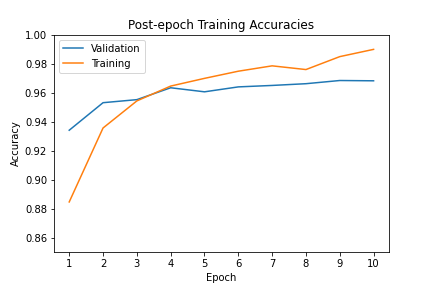

In [10]:
if do_training:
    plt.figure()
    plt.plot(result.history["val_accuracy"], label="Validation")
    plt.plot(result.history["accuracy"], label="Training")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Post-epoch Training Accuracies")
    plt.xticks(np.arange(epochs), np.arange(1, epochs + 1))
    plt.ylim((0.85, 1.0))  # Restrict range of y axis to (0.85, 1) for readability
    plt.savefig("psMNIST-training.png")

    val_loss_min = np.argmin(result.history["val_loss"])
    print(
        f"Maximum validation accuracy: "
        f"{round(result.history['val_accuracy'][val_loss_min] * 100, 2):.2f}%"
    )

else:
    display(Image(filename="psMNIST-training.png"))

## Testing the model

With the training complete, let's use the trained weights to test the model. Since the
weights are saved to file after every epoch, we can simply load the saved weights, then
test it against the permuted sequences in the test set.

In [11]:
model.load_weights(saved_weights_fname)
accuracy = model.evaluate(X_test, Y_test)[1] * 100
print(f"Test accuracy: {round(accuracy, 2):0.2f}%")

  1/313 [..............................] - ETA: 0s - loss: 0.0824 - accuracy: 0.9375

  2/313 [..............................] - ETA: 52s - loss: 0.0547 - accuracy: 0.9688

  3/313 [..............................] - ETA: 1:09 - loss: 0.0619 - accuracy: 0.9583

  4/313 [..............................] - ETA: 1:17 - loss: 0.0563 - accuracy: 0.9609

  5/313 [..............................] - ETA: 1:21 - loss: 0.0614 - accuracy: 0.9563

  6/313 [..............................] - ETA: 1:24 - loss: 0.0530 - accuracy: 0.9635

  7/313 [..............................] - ETA: 1:25 - loss: 0.0470 - accuracy: 0.9688

  8/313 [..............................] - ETA: 1:27 - loss: 0.0671 - accuracy: 0.9648

  9/313 [..............................] - ETA: 1:28 - loss: 0.0619 - accuracy: 0.9688

 10/313 [..............................] - ETA: 1:29 - loss: 0.0592 - accuracy: 0.9719

 11/313 [>.............................] - ETA: 1:30 - loss: 0.0829 - accuracy: 0.9688

 12/313 [>.............................] - ETA: 1:30 - loss: 0.0916 - accuracy: 0.9661

 13/313 [>.............................] - ETA: 1:30 - loss: 0.0895 - accuracy: 0.9663

 14/313 [>.............................] - ETA: 1:31 - loss: 0.0907 - accuracy: 0.9643

 15/313 [>.............................] - ETA: 1:31 - loss: 0.0920 - accuracy: 0.9646

 16/313 [>.............................] - ETA: 1:31 - loss: 0.0945 - accuracy: 0.9648

 17/313 [>.............................] - ETA: 1:31 - loss: 0.0933 - accuracy: 0.9651

 18/313 [>.............................] - ETA: 1:31 - loss: 0.0902 - accuracy: 0.9670

 19/313 [>.............................] - ETA: 1:31 - loss: 0.0928 - accuracy: 0.9671

 20/313 [>.............................] - ETA: 1:31 - loss: 0.0927 - accuracy: 0.9672

 21/313 [=>............................] - ETA: 1:31 - loss: 0.0971 - accuracy: 0.9673

 22/313 [=>............................] - ETA: 1:31 - loss: 0.0958 - accuracy: 0.9673

 23/313 [=>............................] - ETA: 1:31 - loss: 0.0989 - accuracy: 0.9660

 24/313 [=>............................] - ETA: 1:30 - loss: 0.0963 - accuracy: 0.9661

 25/313 [=>............................] - ETA: 1:31 - loss: 0.0951 - accuracy: 0.9663

 26/313 [=>............................] - ETA: 1:31 - loss: 0.0978 - accuracy: 0.9663

 27/313 [=>............................] - ETA: 1:31 - loss: 0.0980 - accuracy: 0.9664

 28/313 [=>............................] - ETA: 1:31 - loss: 0.0976 - accuracy: 0.9654

 29/313 [=>............................] - ETA: 1:31 - loss: 0.1009 - accuracy: 0.9644

 30/313 [=>............................] - ETA: 1:30 - loss: 0.1116 - accuracy: 0.9615

 31/313 [=>............................] - ETA: 1:30 - loss: 0.1110 - accuracy: 0.9617

 32/313 [==>...........................] - ETA: 1:30 - loss: 0.1179 - accuracy: 0.9609

 33/313 [==>...........................] - ETA: 1:30 - loss: 0.1211 - accuracy: 0.9612

 34/313 [==>...........................] - ETA: 1:29 - loss: 0.1202 - accuracy: 0.9614

 35/313 [==>...........................] - ETA: 1:29 - loss: 0.1245 - accuracy: 0.9598

 36/313 [==>...........................] - ETA: 1:29 - loss: 0.1227 - accuracy: 0.9609

 37/313 [==>...........................] - ETA: 1:29 - loss: 0.1232 - accuracy: 0.9603

 38/313 [==>...........................] - ETA: 1:29 - loss: 0.1247 - accuracy: 0.9589

 39/313 [==>...........................] - ETA: 1:28 - loss: 0.1321 - accuracy: 0.9567

 40/313 [==>...........................] - ETA: 1:28 - loss: 0.1304 - accuracy: 0.9570

 41/313 [==>...........................] - ETA: 1:28 - loss: 0.1365 - accuracy: 0.9566

 42/313 [===>..........................] - ETA: 1:28 - loss: 0.1433 - accuracy: 0.9546

 43/313 [===>..........................] - ETA: 1:28 - loss: 0.1405 - accuracy: 0.9557

 44/313 [===>..........................] - ETA: 1:28 - loss: 0.1403 - accuracy: 0.9553

 45/313 [===>..........................] - ETA: 1:27 - loss: 0.1415 - accuracy: 0.9542

 46/313 [===>..........................] - ETA: 1:27 - loss: 0.1401 - accuracy: 0.9545

 47/313 [===>..........................] - ETA: 1:27 - loss: 0.1424 - accuracy: 0.9541

 48/313 [===>..........................] - ETA: 1:27 - loss: 0.1421 - accuracy: 0.9544

 49/313 [===>..........................] - ETA: 1:26 - loss: 0.1434 - accuracy: 0.9534

 50/313 [===>..........................] - ETA: 1:26 - loss: 0.1426 - accuracy: 0.9531

 51/313 [===>..........................] - ETA: 1:26 - loss: 0.1443 - accuracy: 0.9522

 52/313 [===>..........................] - ETA: 1:25 - loss: 0.1426 - accuracy: 0.9525

 53/313 [====>.........................] - ETA: 1:25 - loss: 0.1485 - accuracy: 0.9517

 54/313 [====>.........................] - ETA: 1:25 - loss: 0.1491 - accuracy: 0.9514

 55/313 [====>.........................] - ETA: 1:25 - loss: 0.1566 - accuracy: 0.9489

 56/313 [====>.........................] - ETA: 1:24 - loss: 0.1583 - accuracy: 0.9487

 57/313 [====>.........................] - ETA: 1:24 - loss: 0.1559 - accuracy: 0.9496

 58/313 [====>.........................] - ETA: 1:24 - loss: 0.1553 - accuracy: 0.9494

 59/313 [====>.........................] - ETA: 1:24 - loss: 0.1547 - accuracy: 0.9497

 60/313 [====>.........................] - ETA: 1:23 - loss: 0.1560 - accuracy: 0.9500

 61/313 [====>.........................] - ETA: 1:23 - loss: 0.1565 - accuracy: 0.9498

 62/313 [====>.........................] - ETA: 1:23 - loss: 0.1566 - accuracy: 0.9501

 63/313 [=====>........................] - ETA: 1:22 - loss: 0.1576 - accuracy: 0.9499

 64/313 [=====>........................] - ETA: 1:22 - loss: 0.1671 - accuracy: 0.9482

 65/313 [=====>........................] - ETA: 1:22 - loss: 0.1673 - accuracy: 0.9481

 66/313 [=====>........................] - ETA: 1:22 - loss: 0.1722 - accuracy: 0.9479

 67/313 [=====>........................] - ETA: 1:21 - loss: 0.1766 - accuracy: 0.9473

 68/313 [=====>........................] - ETA: 1:21 - loss: 0.1742 - accuracy: 0.9481

 69/313 [=====>........................] - ETA: 1:21 - loss: 0.1752 - accuracy: 0.9479

 70/313 [=====>........................] - ETA: 1:20 - loss: 0.1732 - accuracy: 0.9487

 71/313 [=====>........................] - ETA: 1:20 - loss: 0.1710 - accuracy: 0.9494

 72/313 [=====>........................] - ETA: 1:20 - loss: 0.1724 - accuracy: 0.9488

 73/313 [=====>........................] - ETA: 1:19 - loss: 0.1719 - accuracy: 0.9491

 74/313 [======>.......................] - ETA: 1:19 - loss: 0.1699 - accuracy: 0.9497

 75/313 [======>.......................] - ETA: 1:19 - loss: 0.1722 - accuracy: 0.9488

 76/313 [======>.......................] - ETA: 1:18 - loss: 0.1749 - accuracy: 0.9478

 77/313 [======>.......................] - ETA: 1:18 - loss: 0.1748 - accuracy: 0.9476

 78/313 [======>.......................] - ETA: 1:18 - loss: 0.1740 - accuracy: 0.9479

 79/313 [======>.......................] - ETA: 1:17 - loss: 0.1720 - accuracy: 0.9486

 80/313 [======>.......................] - ETA: 1:17 - loss: 0.1711 - accuracy: 0.9484

 81/313 [======>.......................] - ETA: 1:17 - loss: 0.1698 - accuracy: 0.9487

 82/313 [======>.......................] - ETA: 1:16 - loss: 0.1705 - accuracy: 0.9489

 83/313 [======>.......................] - ETA: 1:16 - loss: 0.1721 - accuracy: 0.9488

 84/313 [=======>......................] - ETA: 1:16 - loss: 0.1704 - accuracy: 0.9494

 85/313 [=======>......................] - ETA: 1:15 - loss: 0.1696 - accuracy: 0.9496

 86/313 [=======>......................] - ETA: 1:15 - loss: 0.1684 - accuracy: 0.9499

 87/313 [=======>......................] - ETA: 1:14 - loss: 0.1672 - accuracy: 0.9501

 88/313 [=======>......................] - ETA: 1:14 - loss: 0.1655 - accuracy: 0.9506

 89/313 [=======>......................] - ETA: 1:14 - loss: 0.1638 - accuracy: 0.9512

 90/313 [=======>......................] - ETA: 1:14 - loss: 0.1634 - accuracy: 0.9507

 91/313 [=======>......................] - ETA: 1:13 - loss: 0.1638 - accuracy: 0.9505

 92/313 [=======>......................] - ETA: 1:13 - loss: 0.1641 - accuracy: 0.9501

 93/313 [=======>......................] - ETA: 1:13 - loss: 0.1632 - accuracy: 0.9499

 94/313 [========>.....................] - ETA: 1:12 - loss: 0.1635 - accuracy: 0.9498

 95/313 [========>.....................] - ETA: 1:12 - loss: 0.1620 - accuracy: 0.9503

 96/313 [========>.....................] - ETA: 1:12 - loss: 0.1617 - accuracy: 0.9502

 97/313 [========>.....................] - ETA: 1:11 - loss: 0.1615 - accuracy: 0.9504

 98/313 [========>.....................] - ETA: 1:11 - loss: 0.1626 - accuracy: 0.9503

 99/313 [========>.....................] - ETA: 1:11 - loss: 0.1620 - accuracy: 0.9504

100/313 [========>.....................] - ETA: 1:10 - loss: 0.1612 - accuracy: 0.9506

101/313 [========>.....................] - ETA: 1:10 - loss: 0.1613 - accuracy: 0.9508

102/313 [========>.....................] - ETA: 1:10 - loss: 0.1605 - accuracy: 0.9510

103/313 [========>.....................] - ETA: 1:09 - loss: 0.1596 - accuracy: 0.9515

104/313 [========>.....................] - ETA: 1:09 - loss: 0.1584 - accuracy: 0.9516

105/313 [=========>....................] - ETA: 1:09 - loss: 0.1583 - accuracy: 0.9515

106/313 [=========>....................] - ETA: 1:08 - loss: 0.1572 - accuracy: 0.9519

107/313 [=========>....................] - ETA: 1:08 - loss: 0.1562 - accuracy: 0.9524

108/313 [=========>....................] - ETA: 1:08 - loss: 0.1550 - accuracy: 0.9528

109/313 [=========>....................] - ETA: 1:07 - loss: 0.1541 - accuracy: 0.9533

110/313 [=========>....................] - ETA: 1:07 - loss: 0.1549 - accuracy: 0.9528

111/313 [=========>....................] - ETA: 1:07 - loss: 0.1558 - accuracy: 0.9527

112/313 [=========>....................] - ETA: 1:06 - loss: 0.1570 - accuracy: 0.9526

113/313 [=========>....................] - ETA: 1:06 - loss: 0.1563 - accuracy: 0.9527

114/313 [=========>....................] - ETA: 1:06 - loss: 0.1555 - accuracy: 0.9529

115/313 [==========>...................] - ETA: 1:05 - loss: 0.1551 - accuracy: 0.9527

116/313 [==========>...................] - ETA: 1:05 - loss: 0.1547 - accuracy: 0.9529

117/313 [==========>...................] - ETA: 1:05 - loss: 0.1540 - accuracy: 0.9530

118/313 [==========>...................] - ETA: 1:04 - loss: 0.1564 - accuracy: 0.9523

119/313 [==========>...................] - ETA: 1:04 - loss: 0.1576 - accuracy: 0.9519

120/313 [==========>...................] - ETA: 1:04 - loss: 0.1600 - accuracy: 0.9516

121/313 [==========>...................] - ETA: 1:03 - loss: 0.1605 - accuracy: 0.9514

122/313 [==========>...................] - ETA: 1:03 - loss: 0.1599 - accuracy: 0.9513

123/313 [==========>...................] - ETA: 1:03 - loss: 0.1600 - accuracy: 0.9515

124/313 [==========>...................] - ETA: 1:02 - loss: 0.1629 - accuracy: 0.9509

125/313 [==========>...................] - ETA: 1:02 - loss: 0.1623 - accuracy: 0.9510

126/313 [===========>..................] - ETA: 1:02 - loss: 0.1615 - accuracy: 0.9511

127/313 [===========>..................] - ETA: 1:01 - loss: 0.1611 - accuracy: 0.9510

128/313 [===========>..................] - ETA: 1:01 - loss: 0.1641 - accuracy: 0.9504

129/313 [===========>..................] - ETA: 1:01 - loss: 0.1633 - accuracy: 0.9506

130/313 [===========>..................] - ETA: 1:00 - loss: 0.1630 - accuracy: 0.9505

131/313 [===========>..................] - ETA: 1:00 - loss: 0.1637 - accuracy: 0.9504

132/313 [===========>..................] - ETA: 1:00 - loss: 0.1654 - accuracy: 0.9498

133/313 [===========>..................] - ETA: 59s - loss: 0.1669 - accuracy: 0.9497 

134/313 [===========>..................] - ETA: 59s - loss: 0.1665 - accuracy: 0.9496

135/313 [===========>..................] - ETA: 59s - loss: 0.1677 - accuracy: 0.9493

136/313 [============>.................] - ETA: 58s - loss: 0.1678 - accuracy: 0.9494

137/313 [============>.................] - ETA: 58s - loss: 0.1684 - accuracy: 0.9491

138/313 [============>.................] - ETA: 58s - loss: 0.1673 - accuracy: 0.9495

139/313 [============>.................] - ETA: 57s - loss: 0.1676 - accuracy: 0.9494

140/313 [============>.................] - ETA: 57s - loss: 0.1666 - accuracy: 0.9498

141/313 [============>.................] - ETA: 57s - loss: 0.1676 - accuracy: 0.9497

142/313 [============>.................] - ETA: 56s - loss: 0.1674 - accuracy: 0.9498

143/313 [============>.................] - ETA: 56s - loss: 0.1667 - accuracy: 0.9502

144/313 [============>.................] - ETA: 56s - loss: 0.1668 - accuracy: 0.9503

145/313 [============>.................] - ETA: 55s - loss: 0.1666 - accuracy: 0.9502

146/313 [============>.................] - ETA: 55s - loss: 0.1657 - accuracy: 0.9503

147/313 [=============>................] - ETA: 55s - loss: 0.1648 - accuracy: 0.9507

148/313 [=============>................] - ETA: 54s - loss: 0.1652 - accuracy: 0.9508

149/313 [=============>................] - ETA: 54s - loss: 0.1650 - accuracy: 0.9507

150/313 [=============>................] - ETA: 54s - loss: 0.1640 - accuracy: 0.9510

151/313 [=============>................] - ETA: 53s - loss: 0.1657 - accuracy: 0.9507

152/313 [=============>................] - ETA: 53s - loss: 0.1648 - accuracy: 0.9511

153/313 [=============>................] - ETA: 53s - loss: 0.1650 - accuracy: 0.9512

154/313 [=============>................] - ETA: 52s - loss: 0.1642 - accuracy: 0.9515

155/313 [=============>................] - ETA: 52s - loss: 0.1642 - accuracy: 0.9514

156/313 [=============>................] - ETA: 52s - loss: 0.1639 - accuracy: 0.9513

157/313 [==============>...............] - ETA: 51s - loss: 0.1631 - accuracy: 0.9516

158/313 [==============>...............] - ETA: 51s - loss: 0.1621 - accuracy: 0.9519

159/313 [==============>...............] - ETA: 51s - loss: 0.1611 - accuracy: 0.9522

160/313 [==============>...............] - ETA: 50s - loss: 0.1603 - accuracy: 0.9525

161/313 [==============>...............] - ETA: 50s - loss: 0.1593 - accuracy: 0.9528

162/313 [==============>...............] - ETA: 50s - loss: 0.1593 - accuracy: 0.9529

163/313 [==============>...............] - ETA: 49s - loss: 0.1585 - accuracy: 0.9532

164/313 [==============>...............] - ETA: 49s - loss: 0.1576 - accuracy: 0.9535

165/313 [==============>...............] - ETA: 49s - loss: 0.1568 - accuracy: 0.9538

166/313 [==============>...............] - ETA: 48s - loss: 0.1559 - accuracy: 0.9541

167/313 [===============>..............] - ETA: 48s - loss: 0.1557 - accuracy: 0.9542

168/313 [===============>..............] - ETA: 48s - loss: 0.1548 - accuracy: 0.9544

169/313 [===============>..............] - ETA: 47s - loss: 0.1539 - accuracy: 0.9547

170/313 [===============>..............] - ETA: 47s - loss: 0.1530 - accuracy: 0.9550

171/313 [===============>..............] - ETA: 47s - loss: 0.1525 - accuracy: 0.9550

172/313 [===============>..............] - ETA: 46s - loss: 0.1516 - accuracy: 0.9553

173/313 [===============>..............] - ETA: 46s - loss: 0.1508 - accuracy: 0.9556

174/313 [===============>..............] - ETA: 46s - loss: 0.1499 - accuracy: 0.9558

175/313 [===============>..............] - ETA: 45s - loss: 0.1492 - accuracy: 0.9561

176/313 [===============>..............] - ETA: 45s - loss: 0.1485 - accuracy: 0.9563

177/313 [===============>..............] - ETA: 45s - loss: 0.1491 - accuracy: 0.9562

178/313 [================>.............] - ETA: 44s - loss: 0.1485 - accuracy: 0.9565

179/313 [================>.............] - ETA: 44s - loss: 0.1477 - accuracy: 0.9567

180/313 [================>.............] - ETA: 44s - loss: 0.1486 - accuracy: 0.9564

181/313 [================>.............] - ETA: 43s - loss: 0.1478 - accuracy: 0.9567

182/313 [================>.............] - ETA: 43s - loss: 0.1471 - accuracy: 0.9569

183/313 [================>.............] - ETA: 43s - loss: 0.1467 - accuracy: 0.9570

184/313 [================>.............] - ETA: 42s - loss: 0.1466 - accuracy: 0.9570

185/313 [================>.............] - ETA: 42s - loss: 0.1464 - accuracy: 0.9571

186/313 [================>.............] - ETA: 42s - loss: 0.1465 - accuracy: 0.9570

187/313 [================>.............] - ETA: 41s - loss: 0.1478 - accuracy: 0.9569

188/313 [=================>............] - ETA: 41s - loss: 0.1476 - accuracy: 0.9569

189/313 [=================>............] - ETA: 41s - loss: 0.1486 - accuracy: 0.9565

190/313 [=================>............] - ETA: 40s - loss: 0.1485 - accuracy: 0.9566

191/313 [=================>............] - ETA: 40s - loss: 0.1480 - accuracy: 0.9568

192/313 [=================>............] - ETA: 40s - loss: 0.1472 - accuracy: 0.9570

193/313 [=================>............] - ETA: 39s - loss: 0.1482 - accuracy: 0.9568

194/313 [=================>............] - ETA: 39s - loss: 0.1474 - accuracy: 0.9570

195/313 [=================>............] - ETA: 39s - loss: 0.1467 - accuracy: 0.9572

196/313 [=================>............] - ETA: 38s - loss: 0.1459 - accuracy: 0.9574

197/313 [=================>............] - ETA: 38s - loss: 0.1452 - accuracy: 0.9576

198/313 [=================>............] - ETA: 38s - loss: 0.1445 - accuracy: 0.9579

199/313 [==================>...........] - ETA: 37s - loss: 0.1439 - accuracy: 0.9581

200/313 [==================>...........] - ETA: 37s - loss: 0.1435 - accuracy: 0.9581

201/313 [==================>...........] - ETA: 37s - loss: 0.1431 - accuracy: 0.9582

202/313 [==================>...........] - ETA: 36s - loss: 0.1424 - accuracy: 0.9584

203/313 [==================>...........] - ETA: 36s - loss: 0.1417 - accuracy: 0.9586

204/313 [==================>...........] - ETA: 36s - loss: 0.1422 - accuracy: 0.9586

205/313 [==================>...........] - ETA: 35s - loss: 0.1423 - accuracy: 0.9584

206/313 [==================>...........] - ETA: 35s - loss: 0.1427 - accuracy: 0.9580

207/313 [==================>...........] - ETA: 35s - loss: 0.1437 - accuracy: 0.9577

208/313 [==================>...........] - ETA: 34s - loss: 0.1450 - accuracy: 0.9573

209/313 [===================>..........] - ETA: 34s - loss: 0.1444 - accuracy: 0.9575

210/313 [===================>..........] - ETA: 34s - loss: 0.1439 - accuracy: 0.9577

211/313 [===================>..........] - ETA: 33s - loss: 0.1435 - accuracy: 0.9579

212/313 [===================>..........] - ETA: 33s - loss: 0.1439 - accuracy: 0.9578

213/313 [===================>..........] - ETA: 33s - loss: 0.1435 - accuracy: 0.9580

214/313 [===================>..........] - ETA: 32s - loss: 0.1429 - accuracy: 0.9581

215/313 [===================>..........] - ETA: 32s - loss: 0.1423 - accuracy: 0.9583

216/313 [===================>..........] - ETA: 32s - loss: 0.1416 - accuracy: 0.9585

217/313 [===================>..........] - ETA: 31s - loss: 0.1410 - accuracy: 0.9587

218/313 [===================>..........] - ETA: 31s - loss: 0.1404 - accuracy: 0.9589

219/313 [===================>..........] - ETA: 31s - loss: 0.1398 - accuracy: 0.9590

220/313 [====================>.........] - ETA: 30s - loss: 0.1392 - accuracy: 0.9592

221/313 [====================>.........] - ETA: 30s - loss: 0.1393 - accuracy: 0.9591

222/313 [====================>.........] - ETA: 30s - loss: 0.1387 - accuracy: 0.9593

223/313 [====================>.........] - ETA: 29s - loss: 0.1382 - accuracy: 0.9595

224/313 [====================>.........] - ETA: 29s - loss: 0.1376 - accuracy: 0.9597

225/313 [====================>.........] - ETA: 29s - loss: 0.1370 - accuracy: 0.9599

226/313 [====================>.........] - ETA: 28s - loss: 0.1369 - accuracy: 0.9599

227/313 [====================>.........] - ETA: 28s - loss: 0.1366 - accuracy: 0.9599

228/313 [====================>.........] - ETA: 28s - loss: 0.1360 - accuracy: 0.9601

229/313 [====================>.........] - ETA: 27s - loss: 0.1355 - accuracy: 0.9603

230/313 [=====================>........] - ETA: 27s - loss: 0.1349 - accuracy: 0.9605

231/313 [=====================>........] - ETA: 27s - loss: 0.1344 - accuracy: 0.9606

232/313 [=====================>........] - ETA: 26s - loss: 0.1338 - accuracy: 0.9608

233/313 [=====================>........] - ETA: 26s - loss: 0.1337 - accuracy: 0.9608

234/313 [=====================>........] - ETA: 26s - loss: 0.1334 - accuracy: 0.9609

235/313 [=====================>........] - ETA: 25s - loss: 0.1333 - accuracy: 0.9609

236/313 [=====================>........] - ETA: 25s - loss: 0.1329 - accuracy: 0.9611

237/313 [=====================>........] - ETA: 25s - loss: 0.1324 - accuracy: 0.9612

238/313 [=====================>........] - ETA: 24s - loss: 0.1318 - accuracy: 0.9614

239/313 [=====================>........] - ETA: 24s - loss: 0.1315 - accuracy: 0.9614

240/313 [======================>.......] - ETA: 24s - loss: 0.1310 - accuracy: 0.9616

241/313 [======================>.......] - ETA: 23s - loss: 0.1304 - accuracy: 0.9617

242/313 [======================>.......] - ETA: 23s - loss: 0.1300 - accuracy: 0.9619

243/313 [======================>.......] - ETA: 23s - loss: 0.1295 - accuracy: 0.9621

244/313 [======================>.......] - ETA: 22s - loss: 0.1291 - accuracy: 0.9622

245/313 [======================>.......] - ETA: 22s - loss: 0.1290 - accuracy: 0.9622

246/313 [======================>.......] - ETA: 22s - loss: 0.1287 - accuracy: 0.9624

247/313 [======================>.......] - ETA: 21s - loss: 0.1285 - accuracy: 0.9623

248/313 [======================>.......] - ETA: 21s - loss: 0.1286 - accuracy: 0.9622

249/313 [======================>.......] - ETA: 21s - loss: 0.1284 - accuracy: 0.9622

250/313 [======================>.......] - ETA: 20s - loss: 0.1280 - accuracy: 0.9624

251/313 [=======================>......] - ETA: 20s - loss: 0.1275 - accuracy: 0.9625

252/313 [=======================>......] - ETA: 20s - loss: 0.1274 - accuracy: 0.9624

253/313 [=======================>......] - ETA: 19s - loss: 0.1274 - accuracy: 0.9625

254/313 [=======================>......] - ETA: 19s - loss: 0.1269 - accuracy: 0.9626

255/313 [=======================>......] - ETA: 19s - loss: 0.1265 - accuracy: 0.9627

256/313 [=======================>......] - ETA: 18s - loss: 0.1266 - accuracy: 0.9628

257/313 [=======================>......] - ETA: 18s - loss: 0.1261 - accuracy: 0.9629

258/313 [=======================>......] - ETA: 18s - loss: 0.1261 - accuracy: 0.9629

259/313 [=======================>......] - ETA: 17s - loss: 0.1269 - accuracy: 0.9628

260/313 [=======================>......] - ETA: 17s - loss: 0.1273 - accuracy: 0.9627

261/313 [========================>.....] - ETA: 17s - loss: 0.1274 - accuracy: 0.9628

262/313 [========================>.....] - ETA: 16s - loss: 0.1270 - accuracy: 0.9629

263/313 [========================>.....] - ETA: 16s - loss: 0.1268 - accuracy: 0.9629

264/313 [========================>.....] - ETA: 16s - loss: 0.1264 - accuracy: 0.9631

265/313 [========================>.....] - ETA: 15s - loss: 0.1260 - accuracy: 0.9632

266/313 [========================>.....] - ETA: 15s - loss: 0.1256 - accuracy: 0.9633

267/313 [========================>.....] - ETA: 15s - loss: 0.1256 - accuracy: 0.9631

268/313 [========================>.....] - ETA: 14s - loss: 0.1252 - accuracy: 0.9633

269/313 [========================>.....] - ETA: 14s - loss: 0.1247 - accuracy: 0.9634

270/313 [========================>.....] - ETA: 14s - loss: 0.1243 - accuracy: 0.9635

271/313 [========================>.....] - ETA: 13s - loss: 0.1238 - accuracy: 0.9637

272/313 [=========================>....] - ETA: 13s - loss: 0.1234 - accuracy: 0.9638

273/313 [=========================>....] - ETA: 13s - loss: 0.1229 - accuracy: 0.9639

274/313 [=========================>....] - ETA: 12s - loss: 0.1225 - accuracy: 0.9641

275/313 [=========================>....] - ETA: 12s - loss: 0.1220 - accuracy: 0.9642

276/313 [=========================>....] - ETA: 12s - loss: 0.1216 - accuracy: 0.9643

277/313 [=========================>....] - ETA: 11s - loss: 0.1212 - accuracy: 0.9645

278/313 [=========================>....] - ETA: 11s - loss: 0.1208 - accuracy: 0.9646

279/313 [=========================>....] - ETA: 11s - loss: 0.1203 - accuracy: 0.9647

280/313 [=========================>....] - ETA: 10s - loss: 0.1200 - accuracy: 0.9648

281/313 [=========================>....] - ETA: 10s - loss: 0.1196 - accuracy: 0.9650

282/313 [==========================>...] - ETA: 10s - loss: 0.1201 - accuracy: 0.9648

283/313 [==========================>...] - ETA: 9s - loss: 0.1207 - accuracy: 0.9648 

284/313 [==========================>...] - ETA: 9s - loss: 0.1204 - accuracy: 0.9649

285/313 [==========================>...] - ETA: 9s - loss: 0.1200 - accuracy: 0.9650

286/313 [==========================>...] - ETA: 8s - loss: 0.1196 - accuracy: 0.9651

287/313 [==========================>...] - ETA: 8s - loss: 0.1192 - accuracy: 0.9653

288/313 [==========================>...] - ETA: 8s - loss: 0.1189 - accuracy: 0.9654

289/313 [==========================>...] - ETA: 7s - loss: 0.1186 - accuracy: 0.9654

290/313 [==========================>...] - ETA: 7s - loss: 0.1183 - accuracy: 0.9655

291/313 [==========================>...] - ETA: 7s - loss: 0.1180 - accuracy: 0.9655

292/313 [==========================>...] - ETA: 6s - loss: 0.1178 - accuracy: 0.9656

293/313 [===========================>..] - ETA: 6s - loss: 0.1174 - accuracy: 0.9658

294/313 [===========================>..] - ETA: 6s - loss: 0.1172 - accuracy: 0.9659

295/313 [===========================>..] - ETA: 5s - loss: 0.1172 - accuracy: 0.9658

296/313 [===========================>..] - ETA: 5s - loss: 0.1168 - accuracy: 0.9659

297/313 [===========================>..] - ETA: 5s - loss: 0.1168 - accuracy: 0.9659

298/313 [===========================>..] - ETA: 4s - loss: 0.1165 - accuracy: 0.9660

299/313 [===========================>..] - ETA: 4s - loss: 0.1162 - accuracy: 0.9661

300/313 [===========================>..] - ETA: 4s - loss: 0.1163 - accuracy: 0.9661

301/313 [===========================>..] - ETA: 3s - loss: 0.1161 - accuracy: 0.9662

302/313 [===========================>..] - ETA: 3s - loss: 0.1164 - accuracy: 0.9661

303/313 [============================>.] - ETA: 3s - loss: 0.1166 - accuracy: 0.9660

304/313 [============================>.] - ETA: 2s - loss: 0.1164 - accuracy: 0.9661

305/313 [============================>.] - ETA: 2s - loss: 0.1176 - accuracy: 0.9657

306/313 [============================>.] - ETA: 2s - loss: 0.1186 - accuracy: 0.9655

307/313 [============================>.] - ETA: 1s - loss: 0.1188 - accuracy: 0.9653

308/313 [============================>.] - ETA: 1s - loss: 0.1188 - accuracy: 0.9653

309/313 [============================>.] - ETA: 1s - loss: 0.1188 - accuracy: 0.9653

310/313 [============================>.] - ETA: 0s - loss: 0.1194 - accuracy: 0.9652

311/313 [============================>.] - ETA: 0s - loss: 0.1192 - accuracy: 0.9653

312/313 [============================>.] - ETA: 0s - loss: 0.1195 - accuracy: 0.9652

313/313 [==============================] - ETA: 0s - loss: 0.1194 - accuracy: 0.9653

313/313 [==============================] - 103s 330ms/step - loss: 0.1194 - accuracy: 0.9653


Test accuracy: 96.53%


As the results demonstrate, the LMU network has achieved greater than 96% accuracy on
the test dataset. This is considered state-of-the-art for the psMNIST task, which is
made more impressive considering the model has only been trained for 10 epochs.